In [484]:
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Geodesy
using ForwardDiff

In [485]:
#GS Locations
wean_lla = LLA(40.4427217, -79.9479335, 17.0)
wean_ecef = ECEF(wean_lla, wgs84)
gs1_ecef = Array(wean_ecef)./(1000.0)
nrec_lla = LLA(40.4712452, -79.9661841, 16.6)
nrec_ecef = ECEF(nrec_lla, wgs84)
gs2_ecef = Array(nrec_ecef)./(1000.0)
reynolds_lla = LLA(40.4499502, -79.915895, 17.0)
reynolds_ecef = ECEF(reynolds_lla, wgs84)
gs3_ecef = Array(reynolds_ecef)./(1000.0)

3-element Array{Float64,1}:
   851.0346657244661
 -4785.370300111884
  4116.143220174314

In [486]:
function ecef2eci(x_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
end

ecef2eci (generic function with 1 method)

In [487]:
function dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [v; a]
end

function f_c(x)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    return [v; a]
end

function f_d(x)
    h = 10.0 #ten second RK4 step
    
    k1 = f_c(x)
    k2 = f_c(x + 0.5*h*k1)
    k3 = f_c(x + 0.5*h*k2)
    k4 = f_c(x + h*k3)
    
    return (1.0/6.0)*(k1 + 2*k2 + 2*k3 + k4)
end

function A(x)
    return ForwardDiff.jacobian(f_d, x)
end

A (generic function with 1 method)

In [488]:
function g(x,t)
    gs1_eci = ecef2eci(gs1_ecef,t)
    gs2_eci = ecef2eci(gs2_ecef,t)
    gs3_eci = ecef2eci(gs3_ecef,t)

    r1 = norm(x[1:3]-gs1_eci)
    r2 = norm(x[1:3]-gs2_eci)
    r3 = norm(x[1:3]-gs3_eci)
        
    y = [r2-r1; r3-r1; r3-r2]
end

function g_diffable(xt)
    return g(xt[1:end-1], xt[end])
end

function C(x,t)
    C1 = ForwardDiff.jacobian(g_diffable, [x; t]) #3 receivers
    return C1[:,1:end-1]
    #C1 = ForwardDiff.gradient(g_diffable, [x; t]) #2 receivers
    #return C1[1:end-1]
end

C (generic function with 1 method)

In [489]:
#Initial Conditions (polar orbit passing directly over GS at t=0)
μ = 398600.44 #km^3/s^2
Re = 6371.0 #km
r0 = (Re+550)*(gs1_ecef/norm(gs1_ecef))
v0 = cross(r0, cross(r0,[0;0;1]))
v0 = sqrt(μ/norm(r0))*v0/norm(v0)
x0 = [r0; v0]

6-element Array{Float64,1}:
   921.9556818709577
 -5201.028272470356
  4472.084930949979
     0.8559101404321281
    -4.82844558216481
    -5.791927837238977

In [490]:
#Integrate backward for 10 minutes
tspan = (0.0,10.0*60.0)
prob1 = ODEProblem(dynamics!,[r0; -v0],tspan)
soln1 = solve(prob1, Tsit5(), reltol=1e-9, abstol=1e-9)

#Integrate forward for 10 minutes
tspan = (0.0,10.0*60.0)
prob2 = ODEProblem(dynamics!,[r0; v0],tspan)
soln2 = solve(prob2, Tsit5(), reltol=1e-9, abstol=1e-9)

#Sample satellite state every 10 seconds
thist = Array(range(-10.0*60.0, 10.0*60.0, step=10.0))
xhist = zeros(6,length(thist))
for k = 1:length(thist)
    if thist[k] < 0.0
        xhist[:,k] .= soln1(-thist[k])
    else
        xhist[:,k] .= soln2(thist[k])
    end
end

In [491]:
#Calculate elevation
ele = zeros(length(thist))
for k = 1:length(thist)
    gs1_eci = ecef2eci(gs1_ecef,thist[k])
    y = (xhist[1:3,k]-gs1_eci)
    ele[k] = (y/norm(y))'*(gs1_eci/norm(gs1_eci))
end

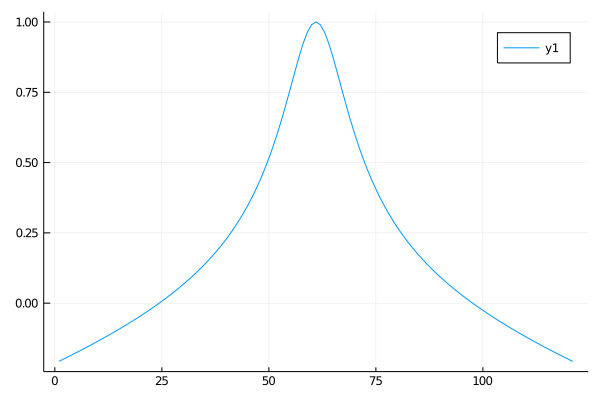

In [492]:
plot(ele)

In [499]:
#Observability Grammian Check
Φ = Array(Diagonal(ones(6)))
J = zeros(3*16,6)
for k = 55:59
    Φ .= A(xhist[:,k])*Φ
    J[(3*(k-55)).+(1:3),:] .= C(xhist[:,k],thist[k])*Φ #3 receivers
    #J[k-54,:] .= Φ*C(xhist[:,1],thist[1]) #2 recievers
end
Jfact = qr(J)
cond(Jfact.R)

5.824108601174033e11

In [551]:
#EKF Covariance
P = Array(Diagonal([1e6*ones(3); 1e4*ones(3)]))
Q = Array(Diagonal([1e-6*ones(3); 1e-8*ones(3)]))
R = Array(Diagonal(0.24*0.24.*ones(3)))
for k = 1:15
    i = k+54
    Akm = A(xhist[:,i-1])
    Ck = C(xhist[:,i],thist[i])
    P̄ = Akm*P*Akm' + Q
    S = Ck*P̄*Ck' + R
    K = P̄*Ck'*inv(S)
    P = (I-K*Ck)*P̄*(I-K*Ck)' + K*R*K'
end

In [552]:
Diagonal(P)

6×6 Diagonal{Float64,Array{Float64,1}}:
 1.01e-6   ⋅        ⋅        ⋅       ⋅       ⋅ 
  ⋅       1.01e-6   ⋅        ⋅       ⋅       ⋅ 
  ⋅        ⋅       1.01e-6   ⋅       ⋅       ⋅ 
  ⋅        ⋅        ⋅       1.0e-8   ⋅       ⋅ 
  ⋅        ⋅        ⋅        ⋅      1.0e-8   ⋅ 
  ⋅        ⋅        ⋅        ⋅       ⋅      1.0e-8

In [205]:
#Generate noisy Measurements
yhist = zeros(3,length(thist))
for k = 1:length(thist)        
        yhist[:,k] .= g(xhist[:,k], thist[k]) + 0.24.*randn(3)
end